In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/FastAI/

/content/drive/MyDrive/FastAI


# MDAuto-Encoder : Autoencoder for malware detection

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
import numpy as np
from tqdm import tqdm

## 1. Dataset (MalwarePix-small)

Batch size: 64
Image shape: torch.Size([1, 28, 28])
Labels: tensor([5, 6, 6, 7, 7, 5, 2, 1, 7, 3])


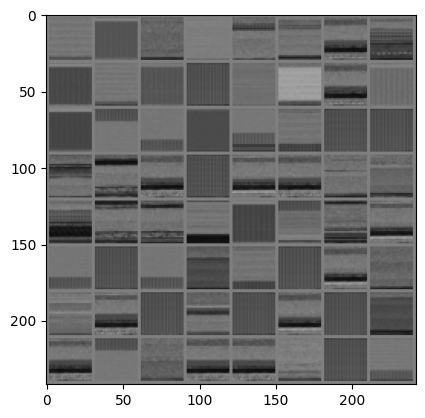

In [4]:
# Get dataset and preprocessing
# 1.Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale
    transforms.Resize((28, 28)),  # Resize images to 28 x 28
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2.Load MalwarePix Dataset
path = './data/img/malwarePix_small'
train_dataset = datasets.ImageFolder(root=path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

# 3.Check the data
for images, labels in train_loader:
    print(f'Batch size: {images.shape[0]}')
    print(f'Image shape: {images.shape[1:]}')
    print(f'Labels: {labels[:10]}')
    break

# Print MalwarePix Dataset
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images))

# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))

## 2. Models (Anomaly Detection Autoencoder)

In [5]:
# CNN based Auto-Encoder model
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder (Convolutional Layers) : Compressed into low-dimensional vectors.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [batch, 32, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [batch, 64, 7, 7]
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=7)  # [batch, 128, 1, 1]
        )
        # Decoder (Transpose Convolutional Layers) : Reconstruct low-dimensional vectors to original image dimensions.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=7),  # [batch, 64, 7, 7]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 32, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 1, 28, 28]
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    5     1     8     8     3     4     7     5


In [6]:
# Residual Blcok
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out


# ResNet based Auto-Encoder model
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        # Encoder (Convolutional Layers with Residual Blocks)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=False),  # Avoid inplace operation
            ResidualBlock(16, 32, stride=2),
            ResidualBlock(32, 64, stride=2),
            nn.ReLU(inplace=False)  # Avoid inplace operation
        )

        # Decoder (Transpose Convolutional Layers)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),  # Avoid inplace operation
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=False),  # Avoid inplace operation
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 3. Train

>> My model using cpu


Epoch 30/30: 100%|██████████| 62/62 [01:19<00:00,  1.29s/batch, loss=0.000615]


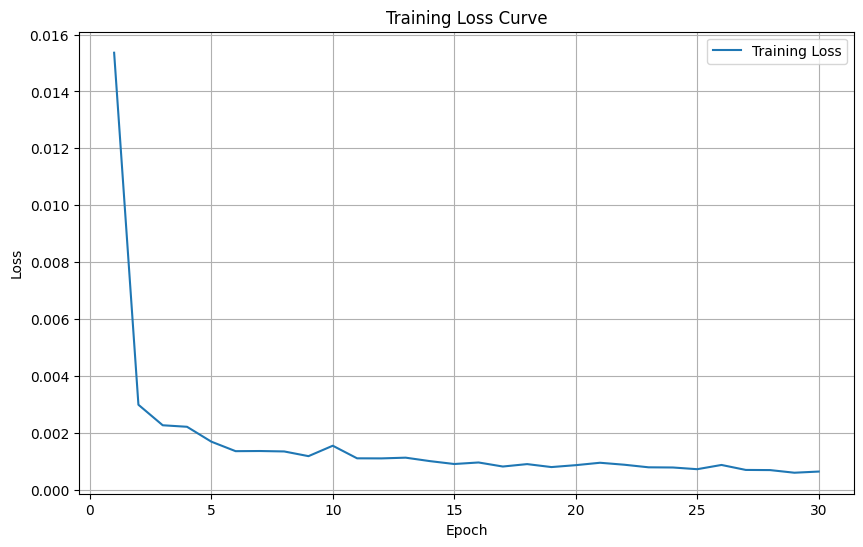

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(">> My model using", device)

# model 1 : CNN based model
#model = CNNAutoencoder().to(device)
# model 2 : ResNet based model
model = ResNetAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

# Training
train_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    train_losses.append(epoch_loss / len(train_loader))

# Plotting the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## 4. Model Inference and performance verification

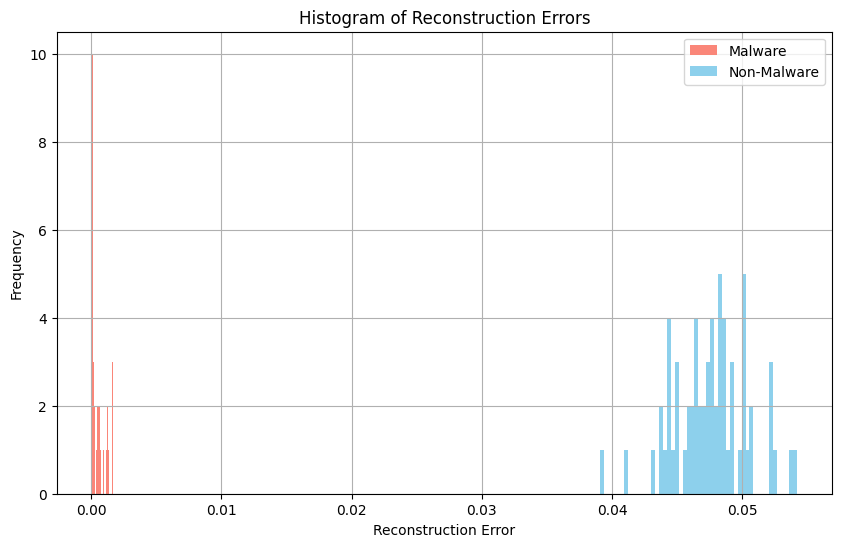

>> Mean Normal data Reconstruction Error Rate: 0.0005
>> Mean Anomalous data Reconstruction Error Rate: 0.0476



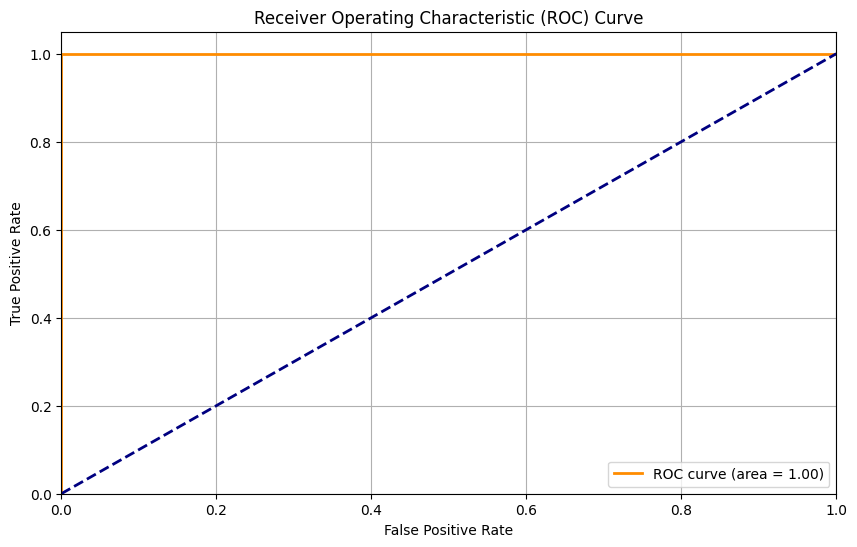

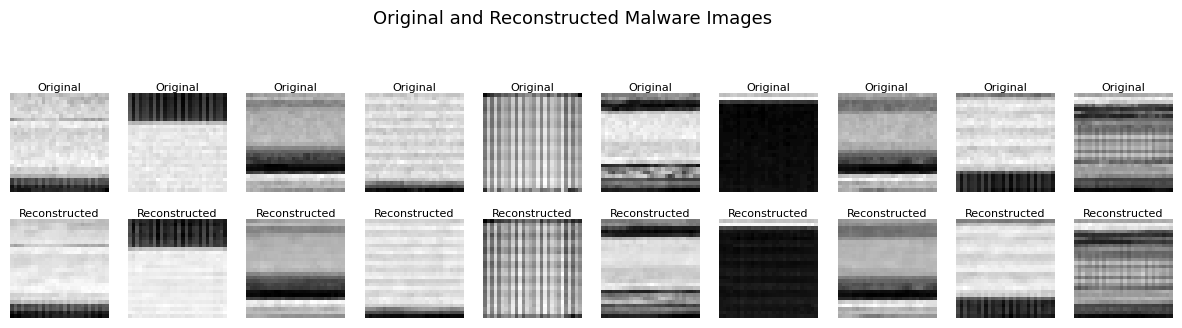

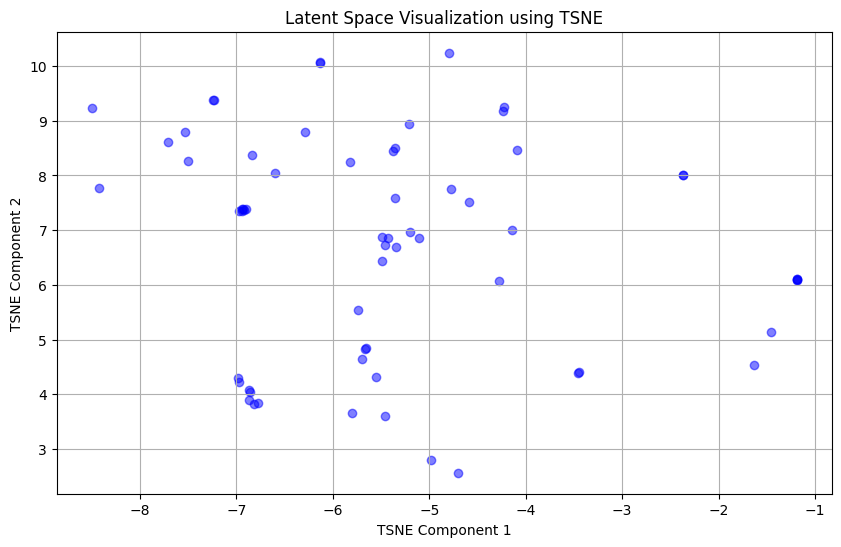

In [13]:
# Reconstruction error : mean + 3 * standard deviation
def compute_reconstruction_error(data, model):
    model.eval() # using trained model
    with torch.no_grad():
        data = data.to(device)
        output = model(data)
        recon_error = torch.mean((data - output) ** 2, dim=[1, 2, 3])
    return recon_error.cpu().detach().numpy()

# 1. Calculate reconstruction error for normal data
normal_data = next(iter(train_loader))[0]
normal_recon_error = compute_reconstruction_error(normal_data, model)
mean_normal_error = np.mean(normal_recon_error)

# 2. Generate random anomalous data (e.g. noise)
anomalous_data = torch.randn_like(normal_data) * 0.25
anomalous_recon_error = compute_reconstruction_error(anomalous_data, model)
mean_anomalous_error = np.mean(anomalous_recon_error)

# 3. Plotting histograms
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.hist(normal_recon_error, bins=50, alpha=0.95, color='salmon', label='Malware')
plt.hist(anomalous_recon_error, bins=50, alpha=0.95, color='skyblue', label='Non-Malware')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# 4. Calculate and print mean error rates
mean_normal_error = np.mean(normal_recon_error)
mean_anomalous_error = np.mean(anomalous_recon_error)
print("==========================================================")
print(f">> Mean Normal data Reconstruction Error Rate: {mean_normal_error:.4f}")
print(f">> Mean Anomalous data Reconstruction Error Rate: {mean_anomalous_error:.4f}")
print("==========================================================\n")

# Generate labels (0 for normal, 1 for anomalous)
labels = np.concatenate([np.zeros(len(normal_recon_error)), np.ones(len(anomalous_recon_error))])
scores = np.concatenate([normal_recon_error, anomalous_recon_error])

# 5. Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("\n\n")

def plot_reconstructed_images(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        output = model(data)

    # Visualization of original and reconstructed images (recovered by the model)
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original', fontsize=8, pad=2)

        axes[1, i].imshow(output[i].cpu().numpy().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed', fontsize=8, pad=2)

    plt.suptitle('Original and Reconstructed Malware Images', fontsize=13, y=1.15)
    plt.show()
    print("\n\n")

# Visualization of Reconstructed IMG
plot_reconstructed_images(model, normal_data[:10])

# 7. Latent space visualization
def plot_latent_space(data, model):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        latent = model.encoder(data)  # Assuming the encoder part of the autoencoder is accessible
        latent = latent.view(latent.size(0), -1).cpu().numpy()

    tsne = TSNE(n_components=2)
    latent_2d = tsne.fit_transform(latent)

    plt.figure(figsize=(10, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('Latent Space Visualization using TSNE')
    plt.grid(True)
    plt.show()
    print("\n\n")

# Example usage
plot_latent_space(next(iter(train_loader))[0], model)